In [1]:
import tensorflow as tf
import numpy as np
import cv2

In [3]:
from ImageServer import ImageServer
from models import emoDAN

In [4]:
imageHeight = 224
imageWidth = 224

In [10]:
emotionDict7 = {0: 'Neutral', 1: 'Happiness', 2: 'Sadness', 3: 'Surprise', 4: 'Fear', 5: 'Disgust', 6: 'Anger'}
emotionDict3 = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}

In [11]:
datasetDir = "/home/workspace/itautkute/voyage/DAN-tensorflow/"
trainSet = np.load(datasetDir + "AffectnetTrain_7.npz")
validationSet = np.load(datasetDir + "AffectnetVal_7.npz")
# validationSet = np.load(datasetDir + 'Test_CK_224_7.npz')

In [12]:
Xtrain = trainSet['Image']

In [13]:
Xvalid = validationSet['Image'][:20]
Yvalid = validationSet['Landmark'][:20]
Yvalid_em = validationSet['Emotion'][:20]

In [14]:
Xtrain.shape, Xvalid.shape

((283849, 224, 224, 1), (20, 224, 224, 1))

In [15]:
nChannels = Xtrain.shape[3]
nSamples = Xtrain.shape[0]
Ytrain = trainSet['Landmark']
Ytrain_em = trainSet['Emotion']
testIdxsTrainSet = range(len(Xvalid))
testIdxsValidSet = range(len(Xvalid))
meanImg = trainSet['MeanShape']
# stdDevImg
initLandmarks = trainSet['Landmark'][0].reshape((1,136))

In [16]:
dan = emoDAN(initLandmarks)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [11]:
STAGE = 2

In [12]:
epochs = 40
batch_size = 50

In [ ]:
with tf.Session() as sess:
    Saver = tf.train.Saver()
    Writer = tf.summary.FileWriter("logs/", sess.graph)
    if STAGE < 2:
        sess.run(tf.global_variables_initializer())
    else:
        Saver.restore(sess,'./Model2-old/Model2')
        print('Pre-trained model has been loaded!')
       
    # Landmark68Test(MeanShape,ImageMean,ImageStd,sess)
    print("Starting training......")
    for epoch in range(epochs):
        Count = 0
        while Count * batch_size < Xtrain.shape[0]:
            RandomIdx = np.random.choice(Xtrain.shape[0],batch_size,False)
            if STAGE == 1 or STAGE == 0:
                sess.run(dan['S1_Optimizer'], feed_dict={dan['InputImage']:Xtrain[RandomIdx],\
                    dan['GroundTruth']:Ytrain[RandomIdx],dan['Emotion_labels']:Ytrain_em[RandomIdx], dan['S1_isTrain']:True,dan['S2_isTrain']:False})
#                 sess.run(dan['S1_Optimizer'], feed_dict={dan['InputImage']:Xvalid,\
#                     dan['GroundTruth']:Yvalid, dan['S1_isTrain']:True,dan['S2_isTrain']:False})
            else:
                sess.run(dan['S2_Optimizer'], feed_dict={dan['InputImage']:Xtrain[RandomIdx],\
                    dan['GroundTruth']:Ytrain[RandomIdx],dan['Emotion_labels']:Ytrain_em[RandomIdx],dan['S1_isTrain']:False,dan['S2_isTrain']:True})

            if Count % 256 == 0:
                TestErr = 0
                BatchErr = 0

                if STAGE == 1 or STAGE == 0:
                    TestErr = sess.run(dan['S1_Cost'], {dan['InputImage']:Xvalid,dan['GroundTruth']:Yvalid,\
                        dan['Emotion_labels']:Yvalid_em, dan['S1_isTrain']:False,dan['S2_isTrain']:False})
                    # print(evaluateBatchError(Yvalid.reshape([-1, 68, 2]), S1_Ret.reshape([-1, 68, 2]), 9))
                    BatchErr = sess.run(dan['S1_Cost'],{dan['InputImage']:Xtrain[RandomIdx],\
                        dan['GroundTruth']:Ytrain[RandomIdx],dan['Emotion_labels']:Ytrain_em[RandomIdx], dan['S1_isTrain']:False,dan['S2_isTrain']:False})
                    print('Epoch: ', epoch, ' Batch: ', Count, 'TestErr:', TestErr, ' BatchErr:', BatchErr)
                else:
                    #Landmark,Img,HeatMap,FeatureUpScale =
                    #sess.run([Ret_dict['S2_InputLandmark'],Ret_dict['S2_InputImage'],Ret_dict['S2_InputHeatmap'],Ret_dict['S2_FeatureUpScale']],{Feed_dict['InputImage']:I[RandomIdx],Feed_dict['GroundTruth']:G[RandomIdx],Feed_dict['S1_isTrain']:False,Feed_dict['S2_isTrain']:False})
                    #for i in range(64):
                    #    TestImage = np.zeros([112,112,1])
                    #    for p in range(68):
                    #        cv2.circle(TestImage,(int(Landmark[i][p *
                    #        2]),int(Landmark[i][p * 2 + 1])),1,(255),-1)

                    #    cv2.imshow('Landmark',TestImage)
                    #    cv2.imshow('Image',Img[i])
                    #    cv2.imshow('HeatMap',HeatMap[i])
                    #    cv2.imshow('FeatureUpScale',FeatureUpScale[i])
                    #    cv2.waitKey(-1)
                    TestErr = sess.run(dan['Joint_Cost'],{dan['InputImage']:Xvalid,dan['GroundTruth']:Yvalid,\
                        dan['Emotion_labels']:Yvalid_em,dan['S1_isTrain']:False,dan['S2_isTrain']:False})
                    BatchErr = sess.run(dan['Joint_Cost'],{dan['InputImage']:Xtrain[RandomIdx],\
                        dan['GroundTruth']:Ytrain[RandomIdx],dan['Emotion_labels']:Ytrain_em[RandomIdx],dan['S1_isTrain']:False,dan['S2_isTrain']:False})
                    accuracy_test = sess.run(dan['Emotion_Accuracy'],{dan['InputImage']:Xvalid,dan['GroundTruth']:Yvalid,\
                        dan['Emotion_labels']:Yvalid_em,dan['S1_isTrain']:False,dan['S2_isTrain']:False})
                    accuracy_train = sess.run(dan['Emotion_Accuracy'],{dan['InputImage']:Xtrain[RandomIdx],\
                        dan['GroundTruth']:Ytrain[RandomIdx],dan['Emotion_labels']:Ytrain_em[RandomIdx],dan['S1_isTrain']:False,dan['S2_isTrain']:False})
                    print('Epoch: ', epoch, ' Batch: ', Count, 'TestErr:', TestErr, ' BatchErr:', BatchErr, 'TestAcc:', accuracy_test, 'TrainAcc:', accuracy_train)
            Count += 1
        Saver.save(sess,'./Model2/Model2')

INFO:tensorflow:Restoring parameters from ./Model2-old/Model2
Pre-trained model has been loaded!
Starting training......
Epoch:  0  Batch:  0 TestErr: 0.9299649  BatchErr: 0.14572607 TestAcc: 0.55 TrainAcc: 0.94


In [6]:
def rmse(GroudTruth, Prediction):
    Gt = np.reshape(GroudTruth, (-1, 68, 2))
    Pt = np.reshape(Prediction, (-1, 68, 2))
#     print(np.power((Gt - Pt),2))
    loss = np.mean(np.sqrt(np.mean(np.power((Gt - Pt),2), 2)), 1)
#     print(loss)
    # norm = tf.sqrt(tf.reduce_sum(((tf.reduce_mean(Gt[:, 36:42, :],1) - \
    #     tf.reduce_mean(Gt[:, 42:48, :],1))**2), 1))
    norm =  np.linalg.norm(np.mean(Gt[:, 36:42, :],1) - np.mean(Gt[:, 42:48, :],1), axis=1)
    # cost = tf.reduce_mean(loss / norm)
#     print(norm)

    return loss/norm

In [20]:
def testExample(images, labels, true_label):
    landm, emt = sess.run([dan['S2_Ret'], dan['Pred_emotion']],
                                       {dan['InputImage']:images,
                                        dan['S1_isTrain']:False,
                                        dan['S2_isTrain']:False})
#     print(landm)
#     print(labels)
    print('Landmarks loss for image', rmse(labels,landm))
    print('Predicted emotion:', emotionDict7[emt[0]])
    print('True emotion', emotionDict7[true_label])
#     print('Joint cost', joint)
    x_s = landm[0][0:][::2]
    y_s = landm[0][1:][::2]
    img = np.reshape(images[0], (224, 224))
    plt.imshow(img, cmap='gray')
    for x, y in zip(x_s, y_s):
        plt.scatter([x],[y])

In [17]:
from matplotlib import pyplot as plt
sess = tf.Session()
Saver = tf.train.Saver()
Saver.restore(sess,'./Model2-old/Model2')

INFO:tensorflow:Restoring parameters from ./Model2-old/Model2


-0.0060018585
Landmarks loss for image [0.02367293]
Predicted emotion: Happiness
True emotion Happiness


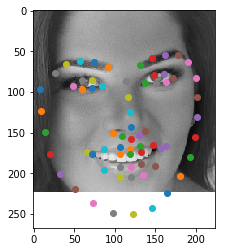

In [31]:
indx =9

print(np.mean(Xvalid[indx]))

testExample([Xvalid[indx]], [Yvalid[indx]], Yvalid_em[indx])

In [32]:
def test_image(filename):
    input_img = cv2.imread(filename,0)
    resized_img = np.array(cv2.resize(input_img, (224,224))).reshape((224,224,1)) / 255.0
    print(np.mean(resized_img))
    landm, emt = sess.run([dan['S2_Ret'], dan['Pred_emotion']],
                                       {dan['InputImage']:[resized_img],
                                        dan['S1_isTrain']:False,
                                        dan['S2_isTrain']:False})
    print('Emotion:', emotionDict7[emt[0]])
#     print(landm)
    x_s = landm[0][0:][::2]
    y_s = landm[0][1:][::2]
    img = np.reshape(resized_img, (224, 224))
    plt.imshow(img, cmap='gray')
    for x, y in zip(x_s, y_s):
        plt.scatter([x],[y])
    plt.show()

0.5588077418467388
Emotion: Neutral


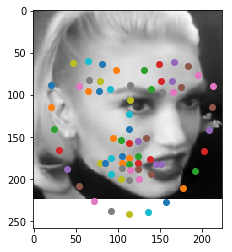

In [35]:
test_image('example_1.png')

0.2375656512605042
Emotion: Neutral


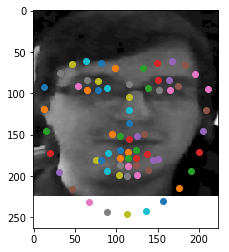

In [36]:
test_image('img015.png')